In [2]:
#Import Modules
import datacube
import datetime
import fiona
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio.mask
import rasterio.features
from shapely import geometry
import seaborn as sns
import sys
import xarray as xr

import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.helpers import write_geotiff

sys.path.append('/g/data/u46/users/ck9738/10_Scripts')
import TasseledCapTools

dc = datacube.Datacube(app='tcw')

%load_ext autoreload

%autoreload 2

In [3]:
#define area of interest
query = {
    
        #Lake Gairdner
'y': (-31.567, -31.710),
'x': (135.712, 135.960),    

        #Tanbar QLD
# 'y': (-26.141, -26.269),
# 'x': (141.482, 141.669), 
    
    #Pambula wetlands
# 'y': (-36.924, -36.988),
# 'x': (149.848, 149.925), 
    
# #ever lasting swamp
# 'y': (-29.365, -29.489),
# 'x': (153.033, 153.200),
    
    
#lake Coleman
# 'y': (-38.103, -38.259),
# 'x': (147.098, 147.421),

         #Macquarie Marshes
# 'y': (-30.512, -30.977),
# 'x': (147.413, 147.809),
    
#     #Daintree Rainforrest
# 'y': (-16.140, -16.209),
# 'x': (145.394, 145.460),    

    
    #Big Gunbower
# 'y': (-35.636, -35.905),
# 'x': (144.102, 144.387),
    
# jerrabombera wetland
# 'y': (-35.288, -35.346),
# 'x': (149.139, 149.191),

#ACT
# 'y': (-35.270, -35.336),
# 'x': (149.021, 149.194),    

#     #lake george
# 'y': (-34.957, -35.221),
# 'x': (149.294, 149.519),   
    
#Kowen
# 'y': (-35.269, -35.354),
# 'x': (149.239, 149.396),   
    
#gunbower
# 'y': (-35.743, -35.909),
# 'x': (144.235, 144.387),
    
    
'time': ('2018-01-01', '2018-04-30'),
'crs': 'EPSG:4326',
'output_crs': 'EPSG: 3577',
'resolution': (-25, 25)
}
    

In [4]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8

<xarray.Dataset>
Dimensions:          (time: 15, x: 952, y: 669)
Coordinates:
  * time             (time) datetime64[ns] 2018-01-01T00:51:27 ... 2018-04-23T00:50:32
  * y                (y) float64 -3.444e+06 -3.444e+06 ... -3.461e+06 -3.461e+06
  * x                (x) float64 3.485e+05 3.486e+05 ... 3.723e+05 3.723e+05
Data variables:
    coastal_aerosol  (time, y, x) int16 637 640 641 632 ... 6450 6417 6396 6409
    blue             (time, y, x) int16 567 566 561 559 ... 6228 6198 6178 6216
    green            (time, y, x) int16 816 830 819 807 ... 6694 6677 6678 6677
    red              (time, y, x) int16 1565 1595 1552 1563 ... 7171 7171 7177
    nir              (time, y, x) int16 2015 2084 2047 2021 ... 7314 7306 7323
    swir1            (time, y, x) int16 3060 3102 3106 3098 ... 3616 3613 3612
    swir2            (time, y, x) int16 2720 2774 2772 2769 ... 3517 3515 3517
Attributes:
    crs:      EPSG: 3577

In [5]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 15, x: 952, y: 669)
Coordinates:
  * time          (time) datetime64[ns] 2018-01-01T00:51:27 ... 2018-04-23T00:50:32
  * y             (y) float64 -3.444e+06 -3.444e+06 ... -3.461e+06 -3.461e+06
  * x             (x) float64 3.485e+05 3.486e+05 ... 3.723e+05 3.723e+05
Data variables:
    pixelquality  (time, y, x) int16 16383 16383 16383 ... 13311 13311 13311
Attributes:
    crs:      EPSG: 3577

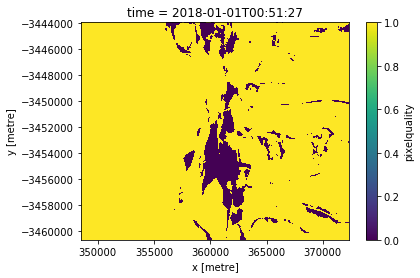

In [6]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality.isel(time=0).plot()

In [7]:
#apply Mask
Masked_lst8_data = data_lst8.where(good_quality)

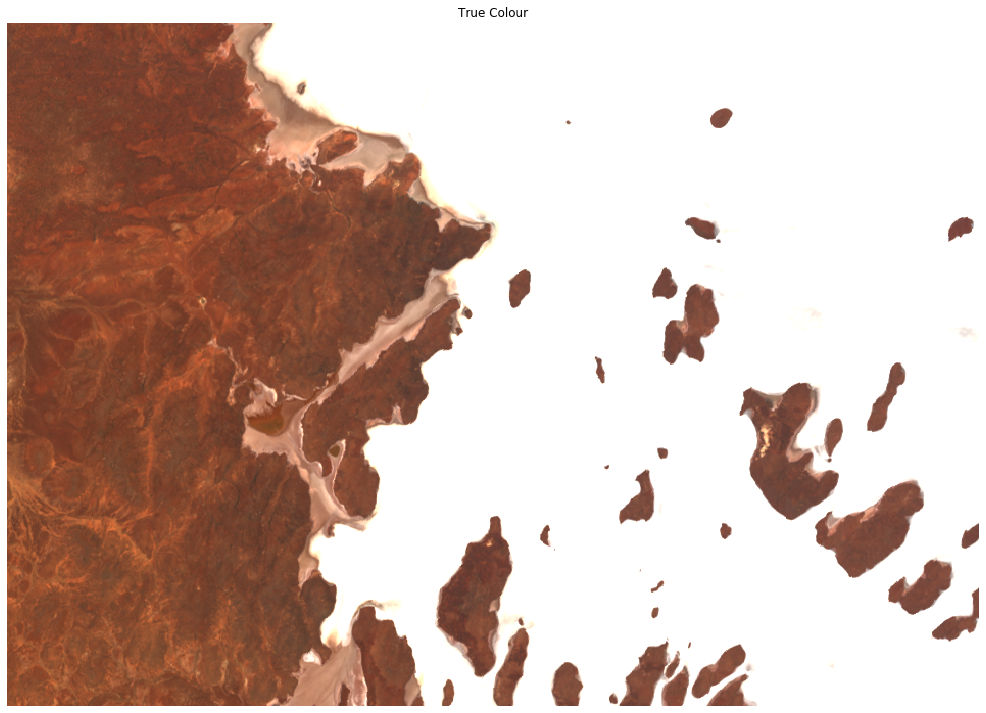

In [8]:
data_lst8_once = data_lst8.isel(time=0)

#Prepare geomedian imagery for plotting

rgb = data_lst8_once.to_array(dim='color').sel(color=[
    'red','green', 'blue']).transpose('y', 'x', 'color')
fake_saturation = 3000.0  #you may need to adjust this to get a clear image. higher numbers will make it darker, 
                                                                            #lower will make it ligher
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

fig = plt.figure(figsize =(15,15)) #edit size of plot 
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #set border dimensions
fig.patch.set_facecolor('white') #make border white 
fig.patch.set_alpha(0.99)#ensure border white
plt.axis('off')#remove axis 
plt.title('True Colour') #add title
plt.imshow(scaled, interpolation = 'nearest') #create image

In [9]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 15, y: 669, x: 952)>
array([[[-31.0435, -31.8505, ...,  47.7502,  48.4961],
        [-29.8465, -31.261 , ...,  47.9002,  48.1292],
        ...,
        [-33.1872, -32.2736, ...,  50.3688,  50.363 ],
        [-32.736 , -33.3847, ...,  47.0998,  46.9692]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]])
C

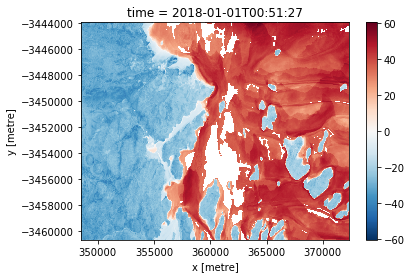

In [10]:
lst_fisher.isel(time=0).plot()

In [11]:
wet_water = lst_fisher.where(lst_fisher>=-10,-1)
wet_water = wet_water.where(lst_fisher<-10,1)

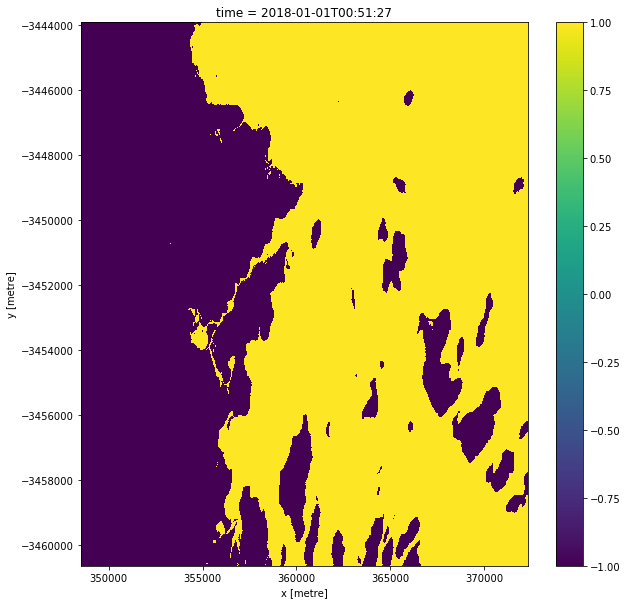

In [12]:
wet_water.isel(time=0).plot(cmap='viridis', figsize =(10,10))